In [6]:
features = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'isChild',
    'Embarked_Q', 'Embarked_S', 'Pclass_3', 'Pclass_2']
# get rid of Embarked_C, Pclass_1 to avoid the dummy variable trap
backward_model_selection(
features
, train_p)

dropped:  Parch
dropped:  Fare
dropped:  Embarked_Q
dropped:  Embarked_S
dropped:  isChild
dropped:  SibSp
dropped:  Pclass_2
dropped:  Age
dropped:  Pclass_3


[['Sex', 'Age', 'SibSp', 'isChild', 'Pclass_3', 'Pclass_2'],
 0.14266454544592372,
 0.8047752808988764]

So we see the predictors that may not be significant are dropped as expected

In [7]:
train = pd.read_csv('train.csv')
train_p = preprocess(train, 'train')
train_data = train_p
test = pd.read_csv('test.csv')
test_p = preprocess(test, 'test')
test_data = test_p

theformula = 'Survived~Sex+Age+SibSp+isChild+Pclass_2+Pclass_3'
model = sm.Logit.from_formula(formula=theformula,data=train_data)
fit = model.fit_regularized(disp=0, maxiter=1000)
ypred = [1 if el >= 0.5 else 0 for el in fit.predict(train_data)]
ytest = train_data['Survived']
print("Training")
measureResult(ypred, ytest, True)

ypred = [1 if el >= 0.5 else 0 for el in fit.predict(test_data)]
writecsv(ypred, test, 'LogiticRegression_pp1.csv')

(712, 13)
30.27273170731707 30.27236220472441
(418, 12)
Training
mse  0.18679775280898878
accuracy 0.8132022471910112
R2 0.2245151991614256


##### Random Forest

1. build multiple randomforest model using different number of estimators and check which one is better
2. choose a good number of estimator and make predictions

accuracy from Kaggle: 0.74641

In [8]:
# build a random forest model
def RandomForestModel (train_X, train_y, num_estimator):
    randomforest = RandomForestClassifier(n_estimators=num_estimator)
    randomforest.fit(train_X, train_y)
    return randomforest

In [9]:
train = pd.read_csv('train.csv')
train = preprocess(train, 'train')
train_X, train_y = splitXy(train)
indexes = []
mses = [] # mse from kfold cross validation
accs = [] # accuracy from kfold cross validation
r2s = [] # r2 from kfold cross validation
allmses = [] # mse on all training data
allaccs = [] # accuracy on all training data
allr2s = [] # r2 on all training data
for i in range(2, 60):
    kfold = KFold(n=len(train_X), n_folds=10)
    tempmses = []
    tempaccs = []
    tempr2s = []
    for train_index, test_index in kfold:
        train_X_train, train_y_train = train_X.values[train_index], train_y.values[train_index]
        train_X_test, train_y_test = train_X.values[test_index], train_y.values[test_index]
        random_forest = RandomForestModel(train_X_train, train_y_train, i)
        y_pred = random_forest.predict(train_X_test)
        mse, acc, r2 = measureResult(y_pred, train_y_test, False)
        tempmses.append(mse)
        tempaccs.append(acc)
        tempr2s.append(r2)
    mses.append(np.mean(tempmses))
    accs.append(np.mean(tempaccs))
    r2s.append(np.mean(tempr2s))
    indexes.append(i)
    random_forest = RandomForestModel(train_X, train_y, i)
    y_pred = random_forest.predict(train_X)
    mse, acc, r2 = measureResult(y_pred, train_y, False)
    allmses.append(mse)
    allaccs.append(acc)
    allr2s.append(r2)

(712, 13)


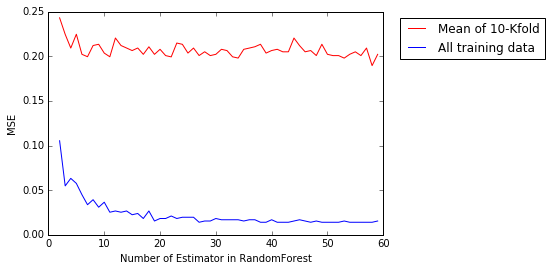

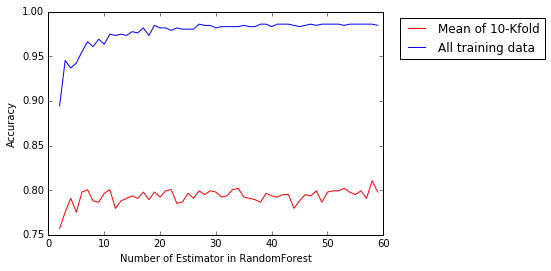

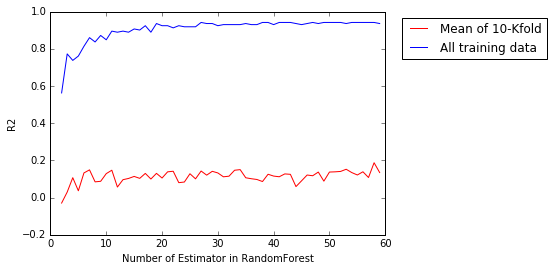

In [10]:
plt.xlabel('Number of Estimator in RandomForest')
plt.ylabel('MSE')
a,=plt.plot(indexes, mses, color='red')
b,=plt.plot(indexes, allmses, color='blue')
plt.legend([a, b], ['Mean of 10-Kfold', 'All training data'], bbox_to_anchor=(1.5, 1))
plt.show()
plt.xlabel('Number of Estimator in RandomForest')
plt.ylabel('Accuracy')
a,=plt.plot(indexes, accs, color='red')
b,=plt.plot(indexes, allaccs, color='blue')
plt.legend([a, b], ['Mean of 10-Kfold', 'All training data'], bbox_to_anchor=(1.5, 1))
plt.show()
plt.xlabel('Number of Estimator in RandomForest')
plt.ylabel('R2')
a,=plt.plot(indexes, r2s, color='red')
b,=plt.plot(indexes, allr2s, color='blue')
plt.legend([a, b], ['Mean of 10-Kfold', 'All training data'], bbox_to_anchor=(1.5, 1))
plt.show()

In [11]:
print('min mse index',mses.index(min(mses)))
print('max accuracy index', accs.index(max(accs)))
print('max r2 index', r2s.index(max(r2s)))

min mse index 56
max accuracy index 56
max r2 index 56


In [12]:
random_forest = RandomForestModel(train_X, train_y, 38)
predy = random_forest.predict(train_X)
print("Training")
measureResult(predy, train_y, True)
test = pd.read_csv('test.csv')
test_X = preprocess(test, 'test')
y_pred = random_forest.predict(test_X)
writecsv(y_pred, test, 'RandomForest_pp1.csv')

Training
mse  0.014044943820224719
accuracy 0.9859550561797753
R2 0.9416928721174004
(418, 12)


###### Importance of the predictors

12 12


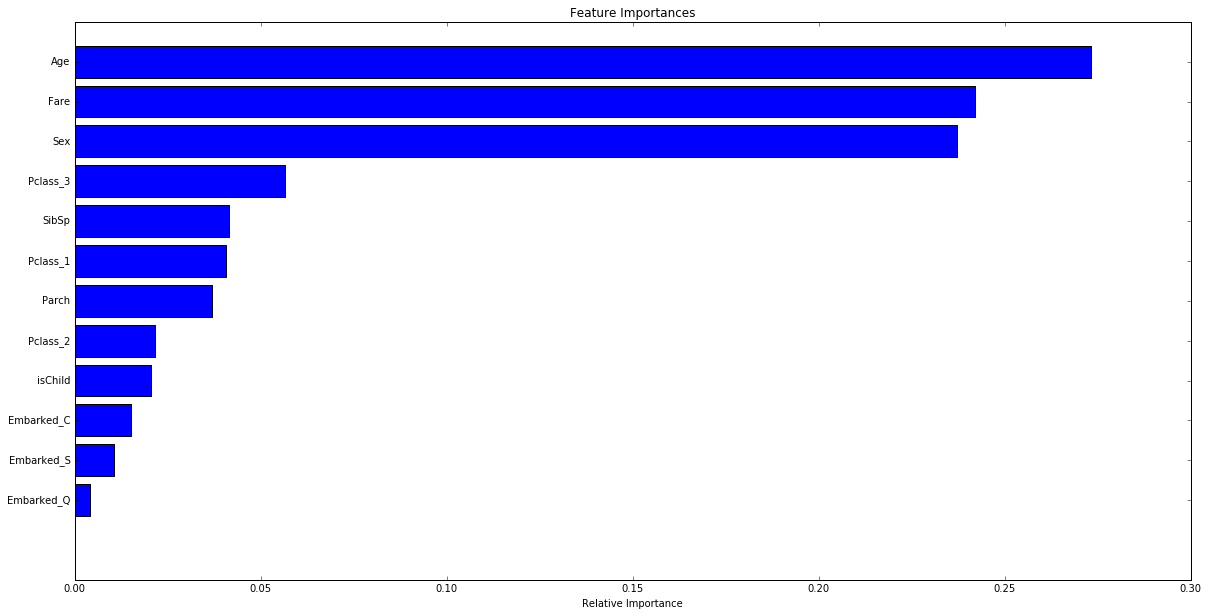

In [13]:
features_names = train_X.columns
importances = random_forest.feature_importances_
print(len(importances), len(features_names))
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features_names[indices])
plt.xlabel('Relative Importance')
plt.show()

##### Dense Neural Network Using Tensorflow

a dense neural network is defined and trained using tensorflow

the dense neural network:
features -> fully connected 128 -> fully connected 64 -> dropout with probability 0.2 -> fully connected 32 -> fully connected 2 -> choose the index of the higher one as result

it is trained with learning rate 1e-3, epoch 1000, batch_size 100

accuracy from Kaggle: 0.75119

In [14]:
# prepare training data
train=pd.read_csv('train.csv')
p_train_all=preprocess(train, 'train')
p_train, p_test=train_test_split(p_train_all, test_size=0.2)
p_train_X, p_train_y = splitXy(p_train)
p_test_X, p_test_y = splitXy(p_test)

test=pd.read_csv('test.csv')
p_test=preprocess(test, 'test')
print(p_train_X.columns)
print('there are na values: ', p_train_all.isnull().values.any())
print(p_train_X.shape)
print(p_test.shape)

(712, 13)
(418, 12)
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'isChild', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')
there are na values:  False
(569, 12)
(418, 12)


In [15]:
# define network
feature_num = p_train_X.shape[1]
X = tf.placeholder(dtype=tf.float32, shape=[None, feature_num])
Y = tf.placeholder(dtype=tf.int32, shape=[None])

logits = X
logits = tf.contrib.layers.fully_connected(logits, 128, tf.nn.relu)
logits = tf.contrib.layers.fully_connected(logits, 64, tf.nn.relu)
logits = tf.nn.dropout(logits, keep_prob=0.2)
logits = tf.contrib.layers.fully_connected(logits, 32, tf.nn.relu)
# logits = tf.contrib.layers.batch_norm(logits)
logits = tf.contrib.layers.fully_connected(logits, 2, tf.nn.relu)
probability = tf.nn.softmax(logits)
out = tf.argmax(input=probability, axis=1)

onehot_labels = tf.one_hot(indices=tf.cast(Y, tf.int32), depth=2)
loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(labels=onehot_labels, logits=probability))

In [16]:
# function used to train the model
def train_model (lr, epochs, batch_size, Logging, X_train, y_train, X_test, y_test, predict_X, print_every=50):
    opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
    losses = []
    with tf.Session() as net:
        net.run(tf.global_variables_initializer())
        for e in range(epochs):
            shuffle_indices = np.random.permutation(len(X_train))
            X_train = X_train[shuffle_indices]
            y_train = y_train[shuffle_indices]
            for i in range(0, len(y_train) // batch_size):
                start = i * batch_size
                batch_x = X_train[start:start + batch_size]
                batch_y = y_train[start:start + batch_size]
                net.run(opt, feed_dict={X: batch_x, Y: batch_y})

            if (e % print_every == 0) and Logging:
                [loss_v, out_v] = net.run([loss, out], feed_dict={X: X_test, Y: y_test})
                losses.append(loss_v)
                mse, acc, r2 = measureResult(out_v, y_test, False)
                print('epoches ' + str(e) + ': ', loss_v, mse, acc, r2)

        print('Training:')
        [loss_v, out_v] = net.run([loss, out], feed_dict={X: X_train, Y: y_train})
        measureResult(out_v, y_train, True)
        
        predict_out_v = net.run(out, feed_dict={X: predict_X})
        
        net.close()
        
        plt.xlabel('Progress')
        plt.ylabel('Loss')
        plt.plot(losses)
        plt.show()

        return predict_out_v

epoches 0:  104.01208 0.46853146853146854 0.5314685314685315 -0.9795454545454549
epoches 20:  89.02574 0.32867132867132864 0.6713286713286714 -0.38863636363636367
epoches 40:  88.08652 0.36363636363636365 0.6363636363636364 -0.5363636363636366
epoches 60:  87.231865 0.3356643356643357 0.6643356643356644 -0.41818181818181843
epoches 80:  88.00969 0.34265734265734266 0.6573426573426573 -0.447727272727273
epoches 100:  82.39212 0.3006993006993007 0.6993006993006993 -0.2704545454545455
epoches 120:  85.15902 0.3006993006993007 0.6993006993006993 -0.2704545454545455
epoches 140:  78.05819 0.25874125874125875 0.7412587412587412 -0.09318181818181848
epoches 160:  77.86827 0.25874125874125875 0.7412587412587412 -0.09318181818181848
epoches 180:  78.97526 0.2517482517482518 0.7482517482517482 -0.06363636363636394
epoches 200:  75.83832 0.22377622377622378 0.7762237762237763 0.05454545454545434
epoches 220:  73.534744 0.23076923076923078 0.7692307692307693 0.0249999999999998
epoches 240:  72.426

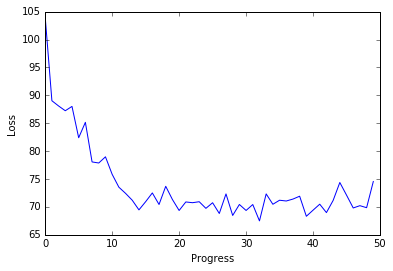

In [17]:
# train model and make predictions
ypred=train_model(
    1e-3, 1000, 100, True,
    p_train_X.values, p_train_y.values, p_test_X.values, p_test_y.values, p_test.values,
    20)
writecsv(ypred, test, 'Dense_pp1.csv')

##### SVM

First, we loaded the training data, ran the same preprocessing as above.

To see if SVM model is good prediction model for the Titanic data set, we did the following:
1. Run the SVC library with the default setting and calculate the accuracy for K-fold cross validation.
2. Explore different C for linear SVM model, and find the optimal C.
3. Find the best model parameters with Grid Search cross validation.
4. Use the our best SVM model to generate the prediction on the testing data and submit to Kaggle.

In [18]:
train=pd.read_csv('train.csv')

In [19]:
proccessed_data=preprocess(train, 'train')
X_train, y_train = splitXy (proccessed_data)

(712, 13)


<b>Step 1:</b> Run K-fold Cross Validation with the default SVC()

In [20]:
svc = SVC()
print(cross_val_score(svc, X_train, y_train, scoring='accuracy', cv = 10))
accuracy = cross_val_score(svc, X_train, y_train, scoring='accuracy', cv = 10).mean() * 100
print("Accuracy of SVM is: " , accuracy)

[0.59722222 0.54166667 0.70833333 0.69444444 0.66197183 0.76056338
 0.69014085 0.69014085 0.74285714 0.8       ]
Accuracy of SVM is:  68.8734071093226


The accuracy was not that bad, but we would like to see if we could improve it with changing the model parameters.

<b>Step 2:</b> Explore different C for linear SVM model

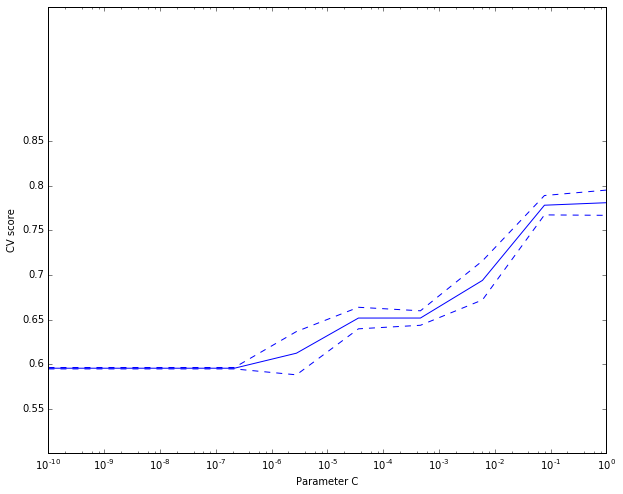

In [21]:
svc = SVC(kernel='linear')

scores = list()
scores_std = list()
C_s = np.logspace(-10, 0, 10)

for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X_train, y_train, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
plt.figure(1, figsize=(10, 8))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0.5, 1.0)
plt.xlim(1.0e-10,1)
plt.show()

From the above graph, it seems that C is optimal when C = 1.

<b>Step 3:</b> Grid Search Cross Validation 

We tried to use Grid Search cross validation to obtain the SVM model with the best parameters for the kernel and C.

In [22]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
model = SVC()
grid = GridSearchCV(model, parameters)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1, 'kernel': 'linear'} with a score of 0.78


The result aligned with our finding in Step 2, so we chose this obtained model as our best SVM model. 

In [23]:
best_model = grid.best_estimator_

<b>Step 4:</b> Generate our prediction on the testing data

In [24]:
test = pd.read_csv('test.csv')
test_X = preprocess(test, 'test')

(418, 12)


In [25]:
pred_y = best_model.predict(test_X)
writecsv(pred_y, test, "SVM.csv")

We submitted <i>"SVM.csv"</i> to Kaggle, and we got a score of 0.76555 for our best SVM model.

##### Multilayer Neural Network with sklearn

First, we loaded the training data, ran the same preprocessing as above.
To see if multilayer neural network model is good prediction model for the Titanic data set, we did the following:
Set the hidden layers of the neural network to be 15 with lpha=1e-5.
Run the MLPClassifier library and calculate the accuracy.
Use the multilayers neural network model to generate the prediction on the testing data and submit to Kaggle.

In [26]:
train=pd.read_csv('train.csv')

In [27]:
proccessed_data=preprocess(train, 'train')
X_train, y_train = splitXy (proccessed_data)

(712, 13)


Step 1: Run the multilayer neural network. Splitting the dataset randomly for training and testing. 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)


#from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
clf.fit(X_train, y_train) 
clf.score(X_test,y_test,sample_weight=None)

0.7872340425531915

Step 2:We get an accuracy of around 78%. Then, we generate our prediction on the testing data.

In [29]:
test = pd.read_csv('test.csv')
test_X = preprocess(test, 'test')

(418, 12)


In [30]:
pred_y = clf.predict(test_X)
writecsv(pred_y, test, "neural.csv")

We submitted "neural.csv" to Kaggle, and we got a score of 0.76555 for our multilayers neyral network model.

##### Choosing the best model

The models with highest accuracy from Kaggle is multilayer neural network and SVM. 

We decide to choose SVM as it is easier to train. 

### Feature Engineering As Preprocessing for Prediction with SVM

The above training on our prediction model was based on the training data after undergoing a simple preprocessing. We dropped some predictors based on the fact that they could be readily used for the model training.

However, we believe that there might be some hidden information within theses predictors that could potentially improve the prediction. So we did the following graphical analysis on some dropped predictors.

##### Cabin

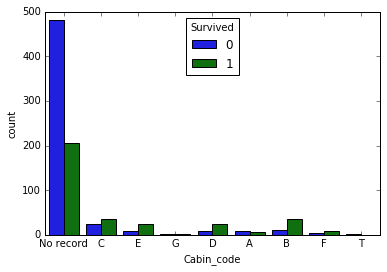

In [31]:
train=pd.read_csv('train.csv')
cabin_list = train['Cabin'].copy()

cabin_record = []
for c in cabin_list:
    if(str(c)[0] == 'A'):
        cabin_record.append ('A')
    elif(str(c)[0] == 'B'):
        cabin_record.append ('B')
    elif(str(c)[0] == 'C'):
        cabin_record.append ('C')
    elif(str(c)[0] == 'D'):
        cabin_record.append ('D')
    elif(str(c)[0] == 'E'):
        cabin_record.append ('E')
    elif(str(c)[0] == 'F'):
        cabin_record.append ('F')
    elif(str(c)[0] == 'G'):
        cabin_record.append ('G')
    elif(str(c)[0] == 'T'):
        cabin_record.append ('T')
    else:
        cabin_record.append ('No record')

train['Cabin_code'] = cabin_record
sns.countplot(x="Cabin_code", hue="Survived", data=train);

From the plot above, it shows that the 'Cabin' attribute contains some information that can help predict the probability of survial. For example, if a passenger had no cabin record, he/she was less likely to survive the accident.

So we think it is a good idea to include the Cabin classification in the preprocessing.

##### Name

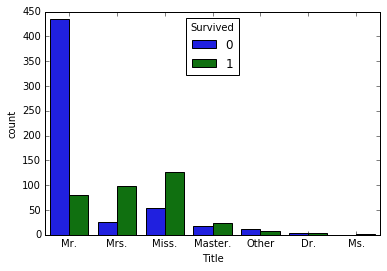

In [32]:
train=pd.read_csv('train.csv')
name_list = train['Name'].copy()

title = []
for n in name_list:
    if('Mr.' in str(n)):
        title.append ('Mr.')
    elif('Mrs.' in str(n)):
        title.append ('Mrs.')
    elif('Miss.' in str(n)):
        title.append ('Miss.')
    elif('Master.' in str(n)):
        title.append ('Master.')
    elif('Ms.' in str(n)):
        title.append ('Ms.')
    elif('Dr.' in str(n)):
        title.append ('Dr.')
    else:
        title.append ('Other')

train['Title'] = title
sns.countplot(x="Title", hue="Survived", data=train);

#### New Preprocessing Function

We decide to use some dropped predictors in previous preprocessing, like Cabin and Name, to see whether it improves the result.
1. we change Sex to 0 and 1 (0 for female, 1 for male)
2. we make Cabin dummy variables. Cabin_0: missing Cabin, Cabin_X: Cabin that starts with alphabet X
3. we drop Ticket
4. we fill missing Age with age mean for corresponding Sex group
5. we fill missing Fare with fare median for all training data
6. we make Name dummy variables. Name_Mr, Name_Mrs, Name_Miss, Name_Master, Name_Ms, Name_Dr. If a name doesn't belongs to any of it, it is Name_Other. 
7. we take a log of (Fare + 1)
8. we add a new feature group_size, group_size = SibSp + Parch
9. we delete PassengerId

In [33]:
def preprocess2 (_data):
    data = _data.copy()
    # treat Sex
    data['Sex'] = [1 if el == 'male' else 0 for el in data['Sex']]
    # treat Embarked and Pclass as categorical predictor
    data = pd.get_dummies(data, columns=['Embarked', 'Pclass'])
    # treat Cabin, classify as 0: Nan, and other label according to their first alphabet
    # make Cabin a categorical predictor
    Cabin_labels = ['0', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
    Cabin_dict = {}
    for label in Cabin_labels:
        Cabin_dict['Cabin_'+label] = data['Cabin'].copy()
    Cabin = data['Cabin'].copy()
    for i in range(0, len(Cabin)):
        if not pd.notnull(Cabin[i]):
            Cabin_dict['Cabin_0'][i] = 1
            for label in Cabin_labels:
                Cabin_dict['Cabin_'+label][i] = 0
        else:
            Cabin_dict['Cabin_0'][i] = 0
            for label in Cabin_labels:
                if Cabin[i][0] == label:
                    Cabin_dict['Cabin_'+label][i] = 1
                else:
                    Cabin_dict['Cabin_'+label][i] = 0
    for label in Cabin_labels:
        data['Cabin_'+label] = Cabin_dict['Cabin_'+label]
    data = data.drop(['Cabin'], 1)
    # drop Ticket
    data = data.drop(['Ticket'], 1)
    # Age median according to Sex
    Age = data['Age'].copy()
    for i in range(0, len(Age)):
        if not pd.notnull(Age[i]):
            if data['Sex'][i] == 0:
                Age[i] = 27
            else:
                Age[i] = 29
    data['Age'] = Age
    # treat missing fare, fill with median
    Fare = data['Fare'].copy()
    for i in range(0, len(Fare)):
        if not pd.notnull(Fare[i]):
            Fare[i] = 14.4542
    data['Fare'] = Fare
    # treat name as categorical
    Name_labels = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Ms.', 'Dr.', 'Other.']
    Name_dict = {}
    for label in Name_labels:
        Name_dict['Name_'+label] = data['Name'].copy()
    for i in range(0, len(data['Name'])):
        found = False
        for label in ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Ms.', 'Dr.']:
            if label in data['Name'][i]:
                Name_dict['Name_'+label][i] = 1
                found = True
            else:
                Name_dict['Name_'+label][i] = 0
        if found:
            Name_dict['Name_'+'Other.'][i] = 0
        else:
            Name_dict['Name_'+'Other.'][i] = 1
    for label in Name_labels:
        short_label=label[0:len(label)-1]
        data['Name_'+short_label] = Name_dict['Name_'+label]
    data = data.drop(['Name'], 1)
    # log Fare
    Fare = data['Fare'].copy()
    for i in range(0, len(Fare)):
        Fare[i] = np.log(Fare[i]+1)
    data['Fare'] = Fare
    # add new feature group_size
    group_size=data['SibSp'].copy()
    for i in range(0,len(group_size)):
        group_size[i]=data['SibSp'][i]+data['Parch'][i]
    data['group_size']=group_size
    # delete PassengerId
    data = data.drop(['PassengerId'], 1)
    print(data.shape)
    
    return data

#### SVM Prediction

In [34]:
train=pd.read_csv('train.csv')
proccessed_data=preprocess2(train)
X_train, y_train = splitXy (proccessed_data)
print(X_train.columns)

(891, 29)
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Cabin_0', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Name_Mr', 'Name_Mrs', 'Name_Miss', 'Name_Master', 'Name_Ms',
       'Name_Dr', 'Name_Other', 'group_size'],
      dtype='object')


In [35]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1, 10]}
model = SVC()
grid = GridSearchCV(model, parameters)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.1, 'kernel': 'linear'} with a score of 0.82


In [36]:
best_model = grid.best_estimator_
ypred=best_model.predict(X_train)
print('Training:')
measureResult(ypred, y_train, True)

Training:
mse  0.17059483726150393
accuracy 0.8294051627384961
R2 0.2786885245901638


(0.17059483726150393, 0.8294051627384961, 0.2786885245901638)

In [37]:
test = pd.read_csv('test.csv')
test_X = preprocess2(test)
pred_y = best_model.predict(test_X)
writecsv(pred_y, test, "SVM_pp_report_final_highest.csv")

(418, 28)


We get accuracy 0.78468 from Kaggle

### **Conclusion**

SVM and Multilayer neural network are the best among all the models we try for simply preprocessed data. For training simplicity and other convenience issues, we choose SVM. 

Age, Sex and Fare may be the most important features. Other features with proper preprocessing may also be useful for prediction improvement. 
For example, people with missing Cabin value tend to be predicted as not survived. (there may be lower chance to get the Cabin information for people who didn't survive)
Younger people, older people and female have higher chance to be predicted as survived. (this corresponds to the common behavior of protecting young people, old people and female)
People with higher Fares have higher chance to be predicted as survived. (higher Fares could possibly indicate higher social and economical status, thus increase the survival chance)

Feature engineering is really powerful for improving prediction accuracy. With proper feature engineering, the prediction accuracy may improves quite a lot.  

We finally use preprocess2 function to do the preprocessing and use SVM with linear kernel and C 0.1 to get our highest accuracy from Kaggle, which is 0.78468. 